/tmp/ipython-input-1280269927.py:239: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Starting inclusive microtrading bot backtest...
Asset: SPY, Strategy: ma, Duration: 12 months, Contribution: $1.0
--------------------------------------------------
Loading historical data for SPY...
Data loaded successfully. Total 245 records.
Month 1: Contribution of $1.00 on 2024-09-30
Month 2: Contribution of $1.00 on 2024-10-31
Month 3: Contribution of $1.00 on 2024-11-30
  -> BUY signal generated because the fast moving average crossed above the slow moving average.
Error: Not enough cash to buy 0.0000 of SPY.
Month 4: Contribution of $1.00 on 2024-12-31
Month 5: Contribution of $1.00 on 2025-01-31
Error: Not enough cash to buy 0.0033 of SPY.
  -> BUY signal generated because the fast moving average crossed above the slow moving average.
Month 6: Contribution of $1.00 on 2025-02-28
Month 7: Contribution of $1.00 on 2025-03-31
Month 8: Contribution of $1.00 on 2025-04-30
Month 9: Contribution of $1.00 on 2025-05-31
Error: Not enough cash to buy 0.0102 of SPY.
  -> BUY signal gener

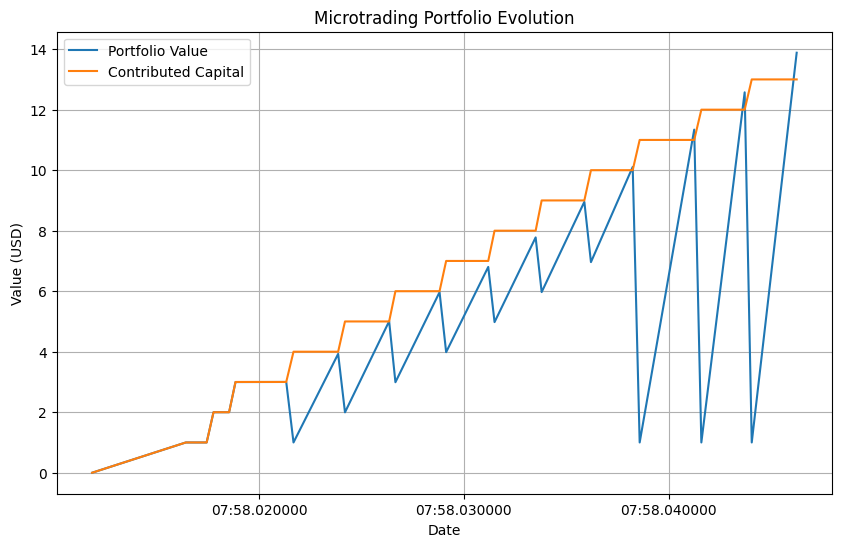

In [21]:
# single_file_bot.py
# Script consolidado para el backtest de un bot de microtrading inclusivo.
# Orquesta la carga de datos, la estrategia y el portafolio en un solo archivo.

import argparse
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
from typing import Dict, List
import yfinance as yf
import numpy as np
import sys

# Dictionary to hold language-specific messages
MESSAGES = {
    "en": {
        "starting_backtest": "Starting inclusive microtrading bot backtest...",
        "asset_strategy_duration_contribution": "Asset: {ticker}, Strategy: {strategy}, Duration: {duration} months, Contribution: ${contribution}",
        "loading_data": "Loading historical data for {ticker}...",
        "no_data_found": "Error: No data found for {ticker} in the specified date range.",
        "data_loaded_successfully": "Data loaded successfully. Total {count} records.",
        "error_loading_data": "Error loading data for {ticker}: {error}",
        "not_enough_cash": "Error: Not enough cash to buy {amount:.4f} of {ticker}.",
        "not_enough_shares": "Error: Not enough shares of {ticker} to sell.",
        "insufficient_data_ma": "Insufficient data to calculate moving averages.",
        "buy_signal_ma": "BUY signal generated because the fast moving average crossed above the slow moving average.",
        "insufficient_data_rsi": "Insufficient data to calculate RSI.",
        "no_trading_signal": "No trading signal.",
        "buy_signal_rsi": "BUY signal generated because RSI indicates an oversold condition.",
        "sell_signal_rsi": "SELL signal generated because RSI indicates an an overbought condition.",
        "data_load_failed_exiting": "Could not load data. Exiting.",
        "month_contribution": "Month {month}: Contribution of ${contribution:.2f} on {date}",
        "contribution_event": "Contribution",
        "deposit_type": "Deposit",
        "automatic_monthly_contribution_reason": "Automatic monthly contribution.",
        "buy_event": "Buy",
        "investment_type": "Investment",
        "buy_reason": "Buy of {ticker}",
        "sell_event": "Sell",
        "liquidation_type": "Liquidation",
        "sell_reason": "Sell of {ticker}",
        "reinvestment_event": "Reinvestment",
        "dividend_type": "Dividend",
        "dividend_reinvestment_reason": "Automatic dividend reinvestment.",
        "total_capital_contributed": "Total Capital Contributed: ${total_contributed:.2f}",
        "final_portfolio_value": "Final Portfolio Value: ${final_value:.2f}",
        "total_return": "Total Return: ${total_return:.2f}",
        "portfolio_evolution_title": "Microtrading Portfolio Evolution",
        "date_label": "Date",
        "value_label": "Value (USD)",
        "portfolio_value_label": "Portfolio Value",
        "contributed_capital_label": "Contributed Capital",
        "log_date": "Date",
        "log_event": "Event",
        "log_type": "Type",
        "log_quantity": "Quantity",
        "log_price": "Price",
        "log_portfolio_value": "Portfolio Value",
        "log_explanation": "Explanation",
        "initial_state_event": "Initial State"

    },
    "es": {
        "starting_backtest": "Iniciando backtest del bot de microtrading inclusivo...",
        "asset_strategy_duration_contribution": "Activo: {ticker}, Estrategia: {strategy}, Duración: {duration} meses, Aportación: ${contribution}",
        "loading_data": "Cargando datos históricos para {ticker}...",
        "no_data_found": "Error: No se encontraron datos para {ticker} en el rango de fechas especificado.",
        "data_loaded_successfully": "Datos cargados exitosamente. Total de {count} registros.",
        "error_loading_data": "Error al cargar datos de {ticker}: {error}",
        "not_enough_cash": "Error: No hay suficiente efectivo para comprar {amount:.4f} de {ticker}.",
        "not_enough_shares": "Error: No hay suficientes acciones de {ticker} para vender.",
        "insufficient_data_ma": "Insuficientes datos para calcular las medias móviles.",
        "buy_signal_ma": "Señal de COMPRA generada porque la media móvil rápida cruzó por encima de la media móvil lenta.",
        "insufficient_data_rsi": "Insuficientes datos para calcular el RSI.",
        "no_trading_signal": "Sin señal de trading.",
        "buy_signal_rsi": "Señal de COMPRA generada porque el RSI indica una condición de sobreventa.",
        "sell_signal_rsi": "Señal de VENTA generada porque el RSI indica una condición de sobrecompra.",
        "data_load_failed_exiting": "No se pudieron cargar los datos. Saliendo.",
        "month_contribution": "Mes {month}: Aportación de ${contribution:.2f} el {date}",
        "contribution_event": "Aportación",
        "deposit_type": "Depósito",
        "automatic_monthly_contribution_reason": "Aportación mensual automática.",
        "buy_event": "Compra",
        "investment_type": "Inversión",
        "buy_reason": "Compra de {ticker}",
        "sell_event": "Venta",
        "liquidation_type": "Liquidación",
        "sell_reason": "Venta de {ticker}",
        "reinvestment_event": "Reinversión",
        "dividend_type": "Dividendo",
        "dividend_reinvestment_reason": "Reinversión automática de dividendos.",
        "total_capital_contributed": "Capital Aportado Total: ${total_contributed:.2f}",
        "final_portfolio_value": "Valor Final del Portafolio: ${final_value:.2f}",
        "total_return": "Retorno Total: ${total_return:.2f}",
        "portfolio_evolution_title": "Evolución del Portafolio de Microtrading",
        "date_label": "Fecha",
        "value_label": "Valor (USD)",
        "portfolio_value_label": "Valor del Portafolio",
        "contributed_capital_label": "Capital Contribuido",
        "log_date": "Fecha",
        "log_event": "Evento",
        "log_type": "Tipo",
        "log_quantity": "Cantidad",
        "log_price": "Precio",
        "log_portfolio_value": "Valor del Portafolio",
        "log_explanation": "Explicación",
        "initial_state_event": "Inicio"
    }
}

def get_message(key: str, lang: str, **kwargs) -> str:
    """Helper function to get a message in the selected language."""
    return MESSAGES.get(lang, MESSAGES["en"]).get(key, MESSAGES["en"][key]).format(**kwargs)


# --- Módulo: portfolio.py ---
class Portfolio:
    """
    Clase para gestionar el estado de un portafolio de trading.
    Permite transacciones de micro-inversión (fracciones de acciones).
    """
    def __init__(self, initial_cash: float = 0, language: str = "en"):
        self.cash = initial_cash
        self.holdings: Dict[str, float] = {}  # { 'ticker': cantidad_fraccionaria }
        self.history: List[Dict] = []
        self.initial_contributions = initial_cash
        self.language = language # Store the language
        self.record_history(event=get_message('initial_state_event', self.language)) # Record initial state

    def deposit_cash(self, amount: float):
        """
        Añade efectivo al portafolio.
        """
        self.cash += amount
        self.initial_contributions += amount
        self.record_history()

    def buy(self, price, amount: float, ticker: str, reason: str):
        """
        Ejecuta una orden de compra de una cantidad fraccionaria de un activo.
        """
        # Extraer el valor escalar del price si es una Serie de pandas
        if isinstance(price, pd.Series):
            price = price.item()

        cost = price * amount
        if self.cash >= cost:
            self.cash -= cost
            self.holdings[ticker] = self.holdings.get(ticker, 0) + amount
            self.record_history(event=get_message('buy_event', self.language), ticker=ticker, amount=amount, price=price, reason=reason)
        else:
            print(get_message('not_enough_cash', self.language, amount=amount, ticker=ticker))


    def sell(self, price, amount: float, ticker: str, reason: str):
        """
        Ejecuta una orden de venta de una cantidad fraccionaria de un activo.
        """
        # Extraer el valor escalar del price si es una Serie de pandas
        if isinstance(price, pd.Series):
            price = price.item()

        if self.holdings.get(ticker, 0) >= amount:
            proceeds = price * amount
            self.cash += proceeds
            self.holdings[ticker] -= amount
            if self.holdings[ticker] < 1e-9: # Eliminar tenencias si son casi cero
                del self.holdings[ticker]
            self.record_history(event=get_message('sell_event', self.language), ticker=ticker, amount=amount, price=price, reason=reason)
        else:
            print(get_message('not_enough_shares', self.language, ticker=ticker))

    def get_value(self, current_price) -> float:
        """
        Calcula el valor total del portafolio (efectivo + tenencias).
        """
        # Extraer el valor escalar del price si es una Serie de pandas
        if isinstance(current_price, pd.Series):
            current_price = current_price.item()

        holdings_value = sum(qty * current_price for qty in self.holdings.values())
        return self.cash + holdings_value

    def record_history(self, event: str = 'Saldo', ticker: str = '', amount: float = 0, price: float = 0, reason: str = ''):
        """
        Registra el estado actual del portafolio en el historial.
        """
        current_value = self.get_value(price) if price else self.cash
        self.history.append({
            'Date': datetime.now(),
            'Event': event,
            'Ticker': ticker,
            'Amount': amount,
            'Price': price,
            'Cash': self.cash,
            'Holdings Value': current_value - self.cash,
            'Portfolio Value': current_value,
            'Capital Contribuido': self.initial_contributions,
            'Reason': reason
        })

    def get_metrics(self) -> Dict:
        """
        Calcula métricas clave como el Retorno Total y el CAGR.
        """
        if not self.history:
            return {}

        df = pd.DataFrame(self.history)
        initial_value = df['Capital Contribuido'].iloc[0]
        final_value = df['Portfolio Value'].iloc[-1]

        total_return = (final_value - initial_value) / initial_value if initial_value > 0 else 0

        # Calcular CAGR
        years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
        cagr = (final_value / initial_value)**(1/years) - 1 if initial_value > 0 and years > 0 else 0

        return {
            "total_return": total_return,
            "cagr": cagr
        }

# --- Módulo: data_loader.py ---
class DataLoader:
    """
    Clase para manejar la carga de datos de mercado.
    """
    def __init__(self, language: str = "en"):
        self.language = language

    def get_historical_data(self, ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Descarga datos históricos para un ticker dado y un rango de fechas.
        """
        try:
            print(get_message('loading_data', self.language, ticker=ticker))
            data = yf.download(ticker, start=start_date, end=end_date)
            if data.empty:
                print(get_message('no_data_found', self.language, ticker=ticker))
                return pd.DataFrame()
            print(get_message('data_loaded_successfully', self.language, count=len(data)))
            return data
        except Exception as e:
            print(get_message('error_loading_data', self.language, ticker=ticker, error=e))
            return pd.DataFrame()

# --- Módulo: strategy.py ---
class Strategy:
    """
    Clase que implementa diferentes estrategias de trading para generar señales.
    """
    def __init__(self, data: pd.DataFrame, language: str = "en"):
        self.data = data
        self.language = language
        self.fast_window = 10  # Ventana para la media móvil rápida (en días)
        self.slow_window = 30  # Ventana para la media móvil lenta (en días)
        self.rsi_window = 14  # Ventana para el RSI (en días)

    def double_ma(self, current_data: pd.DataFrame) -> tuple[pd.Series, str]:
        """
        Estrategia de Doble Media Móvil. Genera una señal de compra cuando la MA rápida
        cruza por encima de la MA lenta.
        """
        if len(current_data) < self.slow_window:
            return pd.Series(0, index=current_data.index), get_message('insufficient_data_ma', self.language)

        fast_ma = current_data['Close'].rolling(window=self.fast_window).mean()
        slow_ma = current_data['Close'].rolling(window=self.slow_window).mean()

        # Create signals based on the comparison, ensuring index alignment
        signals = (fast_ma > slow_ma).reindex(current_data.index, fill_value=False).astype(int)


        explanation = get_message('no_trading_signal', self.language)
        if signals.iloc[-1].item() == 1:
            explanation = get_message('buy_signal_ma', self.language)

        return signals, explanation

    def rsi_strategy(self, current_data: pd.DataFrame) -> tuple[pd.Series, str]:
        """
        Estrategia basada en el Índice de Fuerza Relativa (RSI).
        """
        if len(current_data) < self.rsi_window:
            return pd.Series(0, index=current_data.index), get_message('insufficient_data_rsi', self.language)

        delta = current_data['Close'].diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        # Create signals based on RSI levels, ensuring index alignment
        signals = pd.Series(0, index=current_data.index)
        signals.loc[rsi.index[rsi < 30]] = 1
        signals.loc[rsi.index[rsi > 70]] = -1

        explanation = get_message('no_trading_signal', self.language)
        if signals.iloc[-1].item() == 1:
            explanation = get_message('buy_signal_rsi', self.language)
        elif signals.iloc[-1].item() == -1:
            explanation = get_message('sell_signal_rsi', self.language)


        return signals, explanation

# --- Módulo Principal: bot.py ---
def main():
    """
    Función principal para configurar y ejecutar el backtest del bot de trading.
    """
    parser = argparse.ArgumentParser(description="Bot de microtrading inclusivo para backtesting.")
    parser.add_argument("--ticker", type=str, default="SPY", help="Símbolo del activo (ej. SPY)")
    parser.add_argument("--strategy", type=str, default="ma", choices=["ma", "rsi"], help="Estrategia de trading a usar")
    parser.add_argument("--duration", type=int, default=12, help="Duración del backtest en meses")
    parser.add_argument("--contribution", type=float, default=1.0, help="Aportación mensual en USD")
    parser.add_argument("--language", type=str, default="en", choices=["en", "es"], help="Language for output messages ('en' or 'es')")


    # Check if running in an interactive environment (like Colab) and adjust argument parsing
    if 'ipykernel_launcher.py' in sys.argv[0]:
        args = parser.parse_args([]) # Parse empty list if in interactive mode
    else:
        args = parser.parse_args()

    selected_language = args.language # Store the selected language

    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=args.duration * 30)).strftime('%Y-%m-%d')

    print(get_message('starting_backtest', selected_language))
    print(get_message('asset_strategy_duration_contribution', selected_language,
                      ticker=args.ticker, strategy=args.strategy, duration=args.duration, contribution=args.contribution))
    print("-" * 50)

    data_loader = DataLoader(language=selected_language)
    data = data_loader.get_historical_data(args.ticker, start_date, end_date)
    if data is None or data.empty:
        print(get_message('data_load_failed_exiting', selected_language))
        return

    portfolio = Portfolio(initial_cash=0, language=selected_language)
    trading_strategy = Strategy(data, language=selected_language)

    log_file = f"trading_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    with open(log_file, 'w', newline='') as f:
        log_writer = csv.writer(f)
        log_writer.writerow([
            get_message('log_date', selected_language),
            get_message('log_event', selected_language),
            get_message('log_type', selected_language),
            get_message('log_quantity', selected_language),
            get_message('log_price', selected_language),
            get_message('log_portfolio_value', selected_language),
            get_message('log_explanation', selected_language)
            ])

        # Use 'ME' for month end frequency
        monthly_data = data.resample('ME').last()

        for i, (index, row) in enumerate(monthly_data.iterrows()):
            mes = i + 1
            current_date = index.strftime('%Y-%m-%d')
            current_price = row['Close'].item() # Ensure current_price is a scalar

            portfolio.deposit_cash(args.contribution)
            print(get_message('month_contribution', selected_language, month=mes, contribution=args.contribution, date=current_date))
            log_writer.writerow([
                current_date,
                get_message('contribution_event', selected_language),
                get_message('deposit_type', selected_language),
                args.contribution,
                current_price,
                portfolio.get_value(current_price),
                get_message('automatic_monthly_contribution_reason', selected_language)
                ])

            if args.strategy == "ma":
                signals, explanation = trading_strategy.double_ma(data.loc[:index.strftime('%Y-%m-%d')])
            elif args.strategy == "rsi":
                # Corrected date format
                signals, explanation = trading_strategy.rsi_strategy(data.loc[:index.strftime('%Y-%m-%d')])

            signal_type = signals.iloc[-1].item() # Ensure signal_type is a scalar

            if signal_type == 1:
                amount_to_buy = portfolio.cash / current_price # Removed .item()
                if amount_to_buy > 0:
                    portfolio.buy(current_price, amount_to_buy, args.ticker, get_message('buy_reason', selected_language, ticker=args.ticker)) # Removed .item()
                    print(f"  -> {explanation}")
                    log_writer.writerow([
                        current_date,
                        get_message('buy_event', selected_language),
                        get_message('investment_type', selected_language),
                        amount_to_buy,
                        current_price,
                        portfolio.get_value(current_price),
                        explanation
                        ])

            elif signal_type == -1:
                amount_to_sell = portfolio.holdings.get(args.ticker, 0)
                if amount_to_sell > 0:
                    portfolio.sell(current_price, amount_to_sell, args.ticker, get_message('sell_reason', selected_language, ticker=args.ticker)) # Removed .item()
                    print(f"  -> {explanation}")
                    log_writer.writerow([
                        current_date,
                        get_message('sell_event', selected_language),
                        get_message('liquidation_type', selected_language),
                        amount_to_sell,
                        current_price,
                        portfolio.get_value(current_price),
                        explanation
                        ])

            simulated_dividend_yield = 0.001
            dividend_amount = portfolio.get_value(current_price) * simulated_dividend_yield
            if dividend_amount > 0:
                amount_to_buy = dividend_amount / current_price # Removed .item()
                portfolio.buy(current_price, amount_to_buy, args.ticker, get_message('dividend_reinvestment_reason', selected_language)) # Removed .item()
                log_writer.writerow([
                    current_date,
                    get_message('reinvestment_event', selected_language),
                    get_message('dividend_type', selected_language),
                    amount_to_buy,
                    current_price,
                    portfolio.get_value(current_price),
                    get_message('dividend_reinvestment_reason', selected_language)
                    ])

        print("-" * 50)

        final_value = portfolio.get_value(monthly_data['Close'].iloc[-1])
        total_contributed = args.contribution * args.duration
        total_return = final_value - total_contributed

        print(get_message('total_capital_contributed', selected_language, total_contributed=total_contributed))
        print(get_message('final_portfolio_value', selected_language, final_value=final_value))
        print(get_message('total_return', selected_language, total_return=total_return))


        portfolio_history = pd.DataFrame(portfolio.history)

        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_history['Date'], portfolio_history['Portfolio Value'], label=get_message('portfolio_value_label', selected_language))
        plt.plot(portfolio_history['Date'], portfolio_history['Capital Contribuido'], label=get_message('contributed_capital_label', selected_language))
        plt.title(get_message('portfolio_evolution_title', selected_language))
        plt.xlabel(get_message('date_label', selected_language))
        plt.ylabel(get_message('value_label', selected_language))
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    main()